In [5]:
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import random
import os
import numpy as np
import torch
import sys

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
sys.path.append('../utils')

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True

SEED = 42
seed_everything(SEED)

In [11]:
from training_nn import training_rnn
from evaluation import plot_loss, evaluate_model_rnn
from process_data import get_desc, get_data
from models import RNNembed
from dataset import Abencode2

In [ ]:
train_path = '../dataset/phys_train.csv'
test_path = '../dataset/phys_test.csv'

In [ ]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [7]:
train['repr'] = get_desc(train)
test['repr'] = get_desc(test)


In [12]:
train_target, valid_target, target_test, _ = get_data(train, test, samples = 200, target_ab='REGN33')

In [14]:
def prepare_dataloader(df, dataset_torch, batch_size=5, shuffle=True):
    dataset = dataset_torch(df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    return dataloader

In [15]:
validloader = prepare_dataloader(valid_target, Abencode2, shuffle=False, batch_size=10)
trainloader_target = prepare_dataloader(train_target, Abencode2, shuffle=True, batch_size=5)
testloader = prepare_dataloader(target_test, Abencode2, shuffle=False, batch_size=50)

In [21]:
model = RNNembed().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 30
loss_train_hist, loss_valid_hist = training_rnn(model, criterion, optimizer, num_epochs, trainloader_target, validloader)

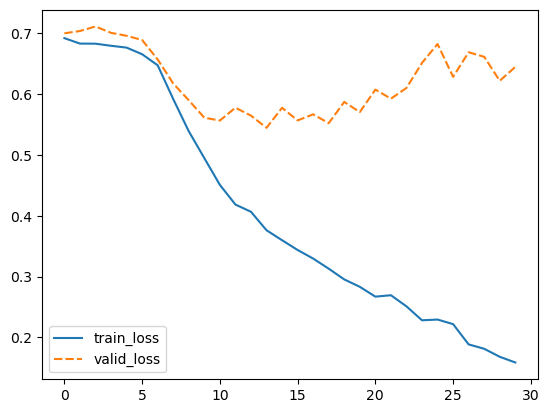

In [116]:
plot_loss(loss_train_hist, loss_valid_hist)

In [117]:
evaluate_model_rnn(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.756083,0.695548,0.790864,0.74015,0.838347


In [17]:
model = RNNembed().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 20
loss_train_hist, loss_valid_hist = training_rnn(model, criterion, optimizer, num_epochs, trainloader_rest, validloader)

100%|██████████| 20/20 [35:33<00:00, 106.66s/it]


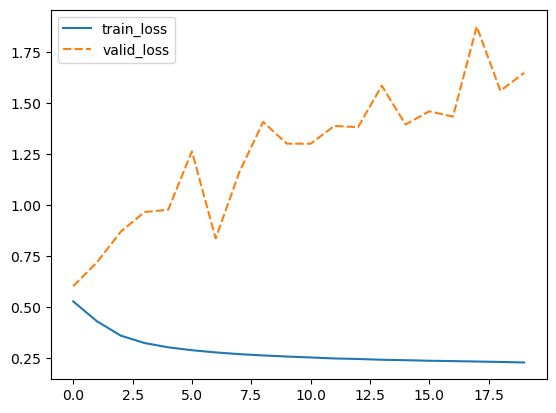

In [18]:
plot_loss(loss_train_hist, loss_valid_hist)

In [19]:
evaluate_model_rnn(testloader, model)   # copy model на этом мементе

,accuracy,recall,precision,f1_scor,auc
0,0.517706,0.041973,0.845921,0.079977,0.743457


In [112]:
def copy_model(model, *args):
    model_copy = type(model)(*args)
    model_copy.load_state_dict(model.state_dict())
    return model_copy.to(device)
    

In [125]:
model_copy = copy_model(model, 41, 24, 140)

In [119]:
def freeze_weights(model, name_layers=['linear1', 'linear2']):
    for name, param in model.named_parameters():
        if not any([layer in name for layer in name_layers]):
            param.requires_grad = False
    return model
    
    

In [ ]:
model_copy = freeze_weights(model_copy)

In [105]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_copy.parameters(), lr=1e-3)  # можно менять learning rate -> 1e-3 лучше себя показал
num_epochs = 10
loss_train_hist, loss_valid_hist = training_rnn(model_copy, criterion, optimizer, num_epochs, trainloader_target, validloader)

100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


In [107]:
evaluate_model_rnn(testloader, model_copy)

,accuracy,recall,precision,f1_scor,auc
0,0.819495,0.890721,0.779381,0.83134,0.903893


#### Нагенерируем выборки предсказаний для разных сэмплов n = 40.

In [168]:
target_test.head()

,junction_aa,v_call,consensus_count,j_call,clonal_frequency,Label,Distance,Antibody,repr,type_ab
2986,KNAGFNCYTPLKQYGFWRTGGRNW,IGHV_RBD,1,IGHJ_RBD,0.000007,1,10,REGN33,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2987,KNKGFNCYSPLYAYGFWRTQGEGF,IGHV_RBD,1,IGHJ_RBD,0.000008,0,9,REGN33,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2988,KNRGFNCYSPLRRYGFWTTAGMGW,IGHV_RBD,1,IGHJ_RBD,0.000008,0,9,REGN33,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2989,TGTGFNCYNPLCTYGFQRTVGRNW,IGHV_RBD,1,IGHJ_RBD,0.000008,0,11,REGN33,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2990,KNKGFNCYAPLSPYGFWPTAGRGW,IGHV_RBD,2,IGHJ_RBD,0.000015,1,8,REGN33,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1


In [162]:
target_df = train.loc[train['Antibody'] == 'REGN33']

In [169]:
seeds = np.arange(40)

In [182]:
target_data = []
for seed in seeds:
    sample_target = target_df.sample(n=200, random_state=seed)
    train_target = sample_target.iloc[:100, :]
    trainloader = prepare_dataloader(train_target, shuffle=True, batch_size=1)
    target_data.append(trainloader)


In [189]:
auc_scratch = []
for i in range(len(target_data)):
    scratch_model = RNNembed().to(device)
    optimizer = torch.optim.Adam(scratch_model.parameters(), lr=1e-5)
    criterion = nn.BCEWithLogitsLoss()
    num_epochs = 30
    _, _ = training_rnn(scratch_model, criterion, optimizer, num_epochs, target_data[i])
    metrics = evaluate_model_rnn(testloader, scratch_model)
    auc_scratch.append(metrics.auc.values[0])


100%|██████████| 30/30 [01:00<00:00,  2.01s/it]


In [199]:
auc_transfer_learn = []
for i in range(len(target_data)):
    model_copy_ = copy_model(model, 41, 24, 140)
    model_copy_ = freeze_weights(model_copy_)
    optimizer = torch.optim.Adam(model_copy_.parameters(), lr=1e-3)
    num_epochs = 10
    _, _ = training_rnn(model_copy_, criterion, optimizer, num_epochs, target_data[i])
    metrics = evaluate_model_rnn(testloader, model_copy_)
    auc_transfer_learn.append(metrics.auc.values[0])


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


In [202]:
auc_scratch = np.array(auc_scratch)
auc_transfer_learn = np.array(auc_transfer_learn)

In [206]:
import seaborn as sns

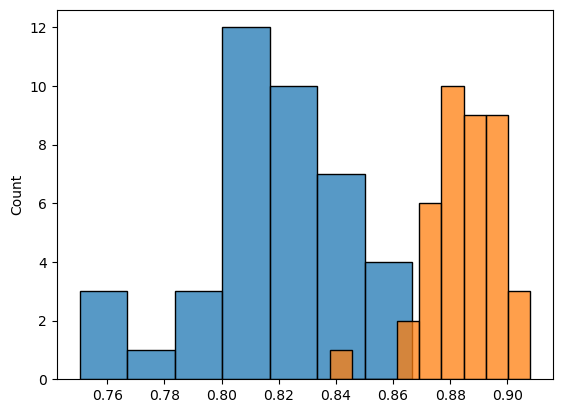

In [213]:
sns.histplot(data=auc_scratch);
sns.histplot(data=auc_transfer_learn);

In [7]:
from scipy import stats

In [218]:
_, pvalue = stats.ttest_ind(auc_transfer_learn, auc_scratch, equal_var=False, random_state=SEED, alternative='greater')

In [219]:
pvalue

1.9054836587266133e-20